In [60]:
# para gestionar ficheros
import os
import pathlib

# para dataframes
import pandas as pd
import numpy as np

# para pintar
import pylab as plt
import seaborn as sns
## para que salga el grafico
import matplotlib.pyplot as plt
import squarify    

%matplotlib inline

# para la conexión SQL
import mysql.connector as conn
from sqlalchemy import create_engine

# mis funciones para este proyect

import src

# display config
pd.options.display.max_rows = None 
pd.options.display.max_columns = None

In [ ]:
dir_path = pathlib.Path('/Users/carlosbasco/Desktop/Projects/SQL-Database-Project/data')
listaFicheros = os.listdir(dir_path) 
#Obtenemos todos los ficheros a leer

In [ ]:
dict_files = {}
for fichero in dir_path.iterdir():
    dict_files[fichero.name] = pd.read_csv(fichero.open(), encoding= "UTF-8")
print(dict_files.keys(), len(dict_files.keys()))

In [ ]:
#### LIMPIEZA PRIMER CSV ####
df = dict_files['actor.csv'] 

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.info(memory_usage="deep")

In [ ]:
df["full_name"] = df.first_name + ' ' + df.last_name

In [ ]:
df.full_name.value_counts()

In [ ]:
df[df.full_name == 'SUSAN DAVIS']

In [ ]:
df = df.drop(df.index[109]).reset_index(drop = True)

In [ ]:
df[df.full_name == 'SUSAN DAVIS']

In [ ]:
src.eliminar_duplicados(df)

In [ ]:
df.last_update = src.normalizar_fechas(df.last_update)

In [ ]:
df.head()

In [ ]:
dictio = zip(df.full_name,df.actor_id)
leyenda_actores=dict(dictio) #Esta leyenda la usaremos más adelante

In [ ]:
leyenda_actores

In [ ]:
src.downcast_types(df)

In [ ]:
df.info()

In [ ]:
dict_files['actor.csv'] = df

In [ ]:
#### LIMPIEZA SEGUNDO CSV ####
df = dict_files['film.csv']

In [ ]:
df.head()

In [ ]:
src.eliminar_duplicados(df)

In [ ]:
df.info()

In [ ]:
df = df.drop(['original_language_id'], axis=1)
df.head()

In [ ]:
df.rating.unique()

In [ ]:
dictio = zip(df.title, df.film_id)
leyenda_films=dict(dictio) #Esta leyenda la usaremos más adelante

In [ ]:
df.last_update = src.normalizar_fechas(df.last_update)

In [ ]:
src.downcast_types(df)

In [ ]:
df.info()

In [ ]:
dict_files['film.csv'] = df

In [ ]:
#### LIMPIEZA TERCER CSV ####
df = dict_files['language.csv']

In [ ]:
df

In [ ]:
df.last_update = src.normalizar_fechas(df.last_update)

In [ ]:
df.head(10)

In [ ]:
src.downcast_types(df)

In [ ]:
dict_files['language.csv'] = df

In [ ]:
#### LIMPIEZA CUARTO CSV ####
df = dict_files['old_HDD.csv']

In [ ]:
df.head(15) #Vamos a usar el autor_id y el title_id en lugar de tener columnas duplicadas con la informacion category_id


In [ ]:
df["full_name"]=df.first_name + ' ' + df.last_name

In [ ]:
df.replace({"title":leyenda_films}, inplace=True)
df.replace({"full_name":leyenda_actores}, inplace=True)
df.rename(columns = {'title':'film_id', 'full_name':'actor_id'}, inplace = True)

In [ ]:
df = df.drop(['first_name','last_name','release_year'], axis=1)

In [ ]:
df

In [ ]:
src.eliminar_duplicados(df)

In [ ]:
src.downcast_types(df)

In [ ]:
df.info()

In [ ]:
dict_files['old_HDD.csv'] = df

In [ ]:
#### LIMPIEZA QUINTO CSV ####
df = dict_files['category.csv']

In [ ]:
df.head(20)

In [ ]:
df.category_id.unique()

In [ ]:
df.last_update = src.normalizar_fechas(df.last_update)
src.downcast_types(df)

In [ ]:
df.head(20)

In [ ]:
dict_files['category.csv'] = df

In [ ]:
#### LIMPIEZA SEXTO CSV ####
df = dict_files['rental.csv'] # Sacar cuanto tiempo tardan en devolver las películas y si vuelven o no los customers

In [ ]:
df.head(100)

In [ ]:
src.eliminar_duplicados(df)

In [ ]:
df = df.drop(['last_update'], axis=1)

In [ ]:
df.info()

In [ ]:
df.rental_date = src.normalizar_fechas(df.rental_date)
df.return_date = src.normalizar_fechas(df.return_date)

In [ ]:
src.downcast_types(df)

In [ ]:
df.info()

In [ ]:
dict_files['rental.csv'] = df

In [ ]:
#### LIMPIEZA SEPTIMO CSV ####
df = dict_files['inventory.csv']

In [ ]:
df.head(100)

In [ ]:
df.shape

In [ ]:
src.eliminar_duplicados(df)

In [ ]:
df.last_update = src.normalizar_fechas(df.last_update)

In [ ]:
src.downcast_types(df)

In [ ]:
df.info()

In [ ]:
df = df.drop(['inventory_id',], axis=1)

In [ ]:
df

In [ ]:
#df = df.groupby(df.store_id).value_counts() #RECORDATORIO Agruparemos las películas por almacen
df.reset_index()

In [ ]:
dict_files['inventory.csv'] = df

In [2]:
#### CONEXION ####

with open("pass/password.txt") as archivo:
    host_line = archivo.readline().rstrip('\n')
    user_line = archivo.readline().rstrip('\n')
    passwd_line = archivo.readline().rstrip('\n')

In [ ]:
#### CREAMOS UNA NUEVA BASE DE DATOS ####

str_conn='mysql+pymysql://'+user_line+':'+passwd_line+'@'+host_line+':3306'

cursor=create_engine(str_conn)

cursor.execute('drop database if exists video_store;')
cursor.execute('create database video_store;')

In [ ]:
#### GENERAMOS LAS TABLAS DE SQL ####

str_conn='mysql+pymysql://'+user_line+':'+passwd_line+'@'+host_line+':3306'+'/video_store'

cursor=create_engine(str_conn)

for element in dict_files:
    name_aux = (element.split('.'))[0]
    dict_files[element].to_sql(name=name_aux, con=cursor, if_exists='replace', index=False)

In [ ]:
#### RELACIONES DE LAS TABLAS ####

lista_querys = ['ALTER TABLE `video_store`.`category` CHANGE COLUMN `category_id` `category_id` SMALLINT NOT NULL ,ADD PRIMARY KEY (`category_id`);',
                'ALTER TABLE `video_store`.`actor` CHANGE COLUMN `actor_id` `actor_id` SMALLINT NOT NULL ,ADD PRIMARY KEY (`actor_id`)',
                'ALTER TABLE `video_store`.`film` CHANGE COLUMN `film_id` `film_id` SMALLINT NOT NULL ,ADD PRIMARY KEY (`film_id`),ADD INDEX `language_id_idx` (`language_id` ASC) VISIBLE;;',
                'ALTER TABLE `video_store`.`language` CHANGE COLUMN `language_id` `language_id` SMALLINT NOT NULL ,ADD PRIMARY KEY (`language_id`);',
                'ALTER TABLE `video_store`.`film` ADD CONSTRAINT `language_id`  FOREIGN KEY (`language_id`)  REFERENCES `video_store`.`language` (`language_id`)  ON DELETE NO ACTION  ON UPDATE NO ACTION;',
                'ALTER TABLE `video_store`.`inventory` ADD INDEX `film_id_idx` (`film_id` ASC) VISIBLE;',
                'ALTER TABLE `video_store`.`inventory` ADD CONSTRAINT `film_id`  FOREIGN KEY (`film_id`)  REFERENCES `video_store`.`film` (`film_id`)  ON DELETE NO ACTION  ON UPDATE NO ACTION;',
                'ALTER TABLE `video_store`.`old_HDD` ADD INDEX `film_id_idx` (`film_id` ASC) VISIBLE,ADD INDEX `category_id_idx` (`category_id` ASC) VISIBLE,ADD INDEX `actor_id_idx` (`actor_id` ASC) VISIBLE;',
                'ALTER TABLE `video_store`.`old_HDD` ADD CONSTRAINT `film_id_2`  FOREIGN KEY (`film_id`)  REFERENCES `video_store`.`film` (`film_id`)  ON DELETE NO ACTION ON UPDATE NO ACTION,ADD CONSTRAINT `category_id`  FOREIGN KEY (`category_id`)REFERENCES `video_store`.`category` (`category_id`)  ON DELETE NO ACTION  ON UPDATE NO ACTION,ADD CONSTRAINT `actor_id`  FOREIGN KEY (`actor_id`)  REFERENCES `video_store`.`actor` (`actor_id`)  ON DELETE NO ACTION ON UPDATE NO ACTION;'
               ]

In [ ]:
for query in lista_querys:
    cursor.execute(query)

In [61]:
#### Obtenemos la data de algunas querys para pintar graficos ####
str_conn='mysql+pymysql://'+user_line+':'+passwd_line+'@'+host_line+':3306'+'/video_store'

cursor=create_engine(str_conn)

aux = pd.DataFrame.from_records(cursor.execute('select c.name as Category, count(c.name) as Count, count(c.name)/1000*100 as Percent from film as f inner join old_HDD as o on o.film_id = f.film_id inner join category as c on c.category_id = o.category_id group by c.name;'))

In [62]:
aux.columns = ['Category', 'Num.Films', 'Percent']

In [90]:
aux.index = aux.Category
aux = aux.drop(['Category'], axis = 1)

In [91]:
aux

,Num.Films,Percent
Category,,
Action,77,7.7000
Animation,75,7.5000
Children,62,6.2000
Classics,55,5.5000
Comedy,46,4.6000
Documentary,72,7.2000
Drama,74,7.4000
Family,57,5.7000
Foreign,64,6.4000


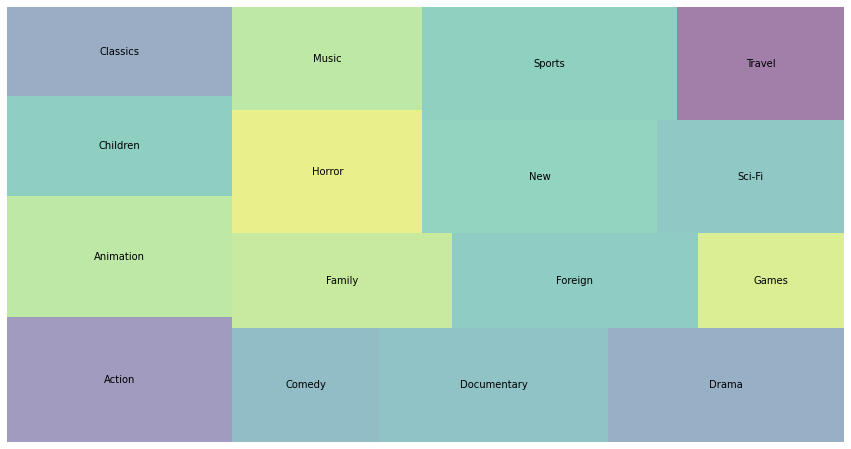

In [115]:
#Tree map
plt.figure(figsize=(15,8))
squarify.plot(sizes=aux['Num.Films'], label=aux.index, alpha=.5 )
plt.axis('off')
plt.show()

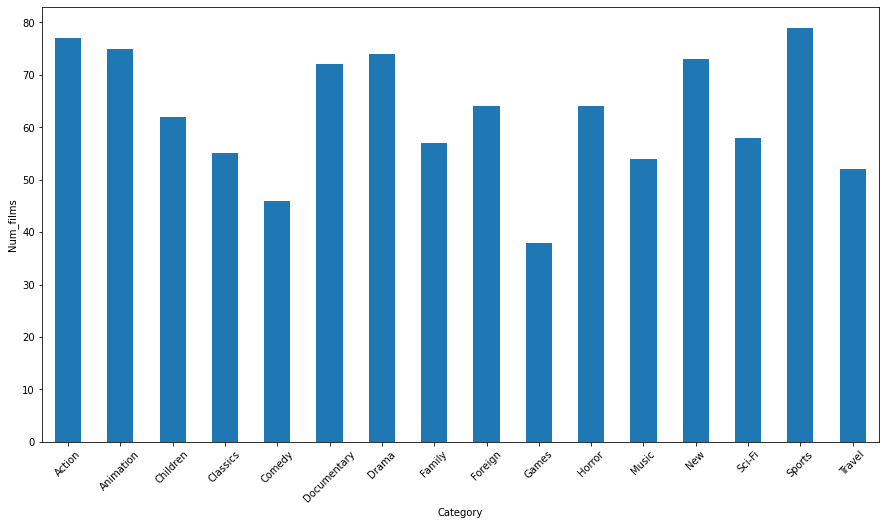

In [114]:
#Plot bar
plt.figure(figsize=(15,8))

aux["Num.Films"].plot.bar(rot=45);
plt.ylabel('Num_films');